Let's start with the initial data loading and exploratory data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
df = pd.read_csv('SeoulBikeData.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (8760, 14)

Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']

First few rows:
            Date  Rented Bike Count  Hour  Temperature(�C)  Humidity(%)  \
0     01/12/2017                254     0             -5.2           37   
1     01/12/2017                204     1             -5.5           38   
2     01/12/2017                173     2             -6.0           39   
3     01/12/2017                107     3             -6.2           40   
4     01/12/2017                 78     4             -6.0           36   
...          ...                ...   ...              ...          ...   
8755  30/11/2018               1003    19              4.2           34   
8756  30/11/2018                764    20              3.4           37   
8757  30/11/2018              

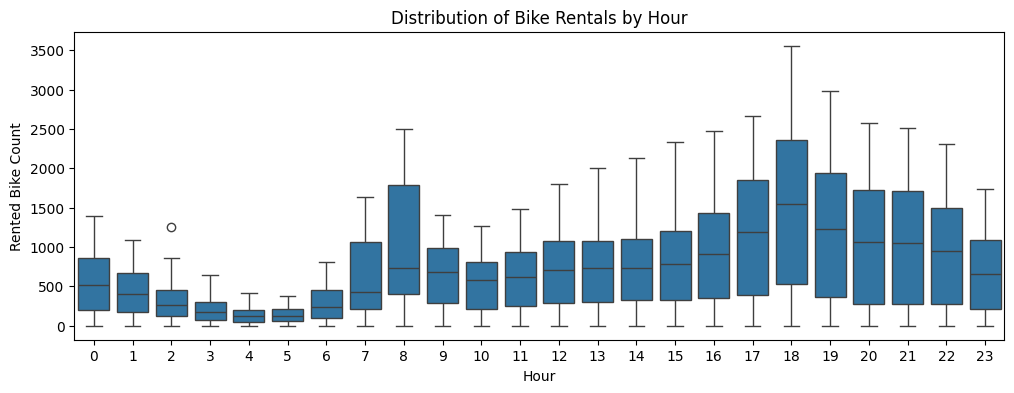

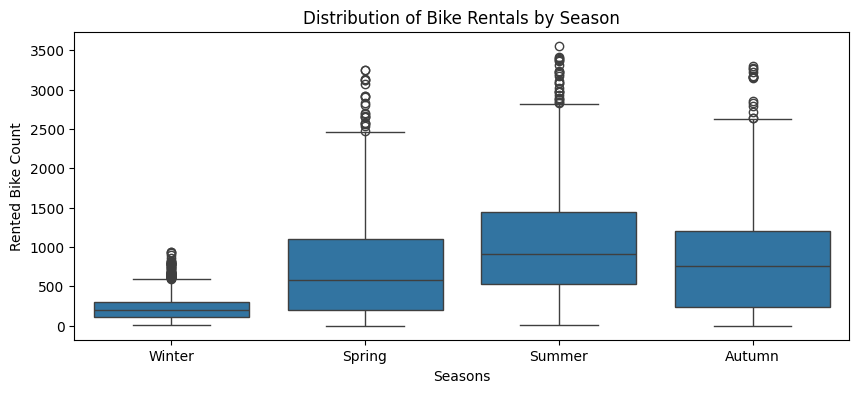

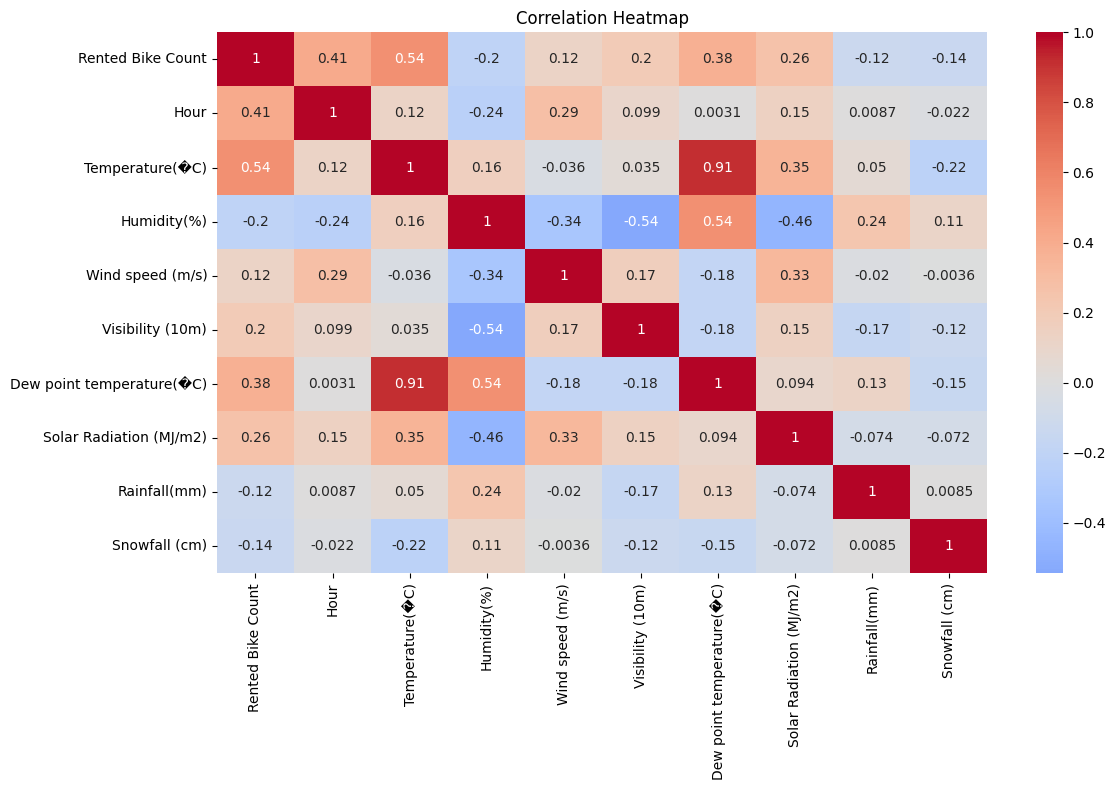

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Create visualization for bike rentals by hour
plt.figure(figsize=(12, 4))
sns.boxplot(x='Hour', y='Rented Bike Count', data=df)
plt.title('Distribution of Bike Rentals by Hour')
plt.show()

# Create visualization for bike rentals by season
plt.figure(figsize=(10, 4))
sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
plt.title('Distribution of Bike Rentals by Season')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Create cyclical features for Hour
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)

# Create interaction features
df['Temp_Hour'] = df['Temperature(�C)'] * df['Hour']
df['Humidity_Temp'] = df['Humidity(%)'] * df['Temperature(�C)']

# Prepare categorical variables for one-hot encoding
categorical_features = ['Seasons', 'Holiday', 'Functioning Day']
numeric_features = ['Hour_sin', 'Hour_cos', 'Temperature(�C)', 'Humidity(%)',
                   'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',
                   'Rainfall(mm)', 'Snowfall (cm)', 'Temp_Hour', 'Humidity_Temp']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Prepare X and y
X = df[numeric_features + categorical_features]
y = df['Rented Bike Count']

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed shapes:")
print("X_train:", X_train_transformed.shape)
print("X_val:", X_val_transformed.shape)
print("X_test:", X_test_transformed.shape)

Transformed shapes:
X_train: (5256, 16)
X_val: (1752, 16)
X_test: (1752, 16)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

# Build the model
model = models.Sequential([
    layers.Input(shape=(X_train_transformed.shape[1],)),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    X_train_transformed, y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

2025-05-11 10:13:07.684256: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 10:13:07.686806: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 10:13:07.717628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 10:13:07.717651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 10:13:07.718658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

55/55 [==============================] - 0s 763us/step


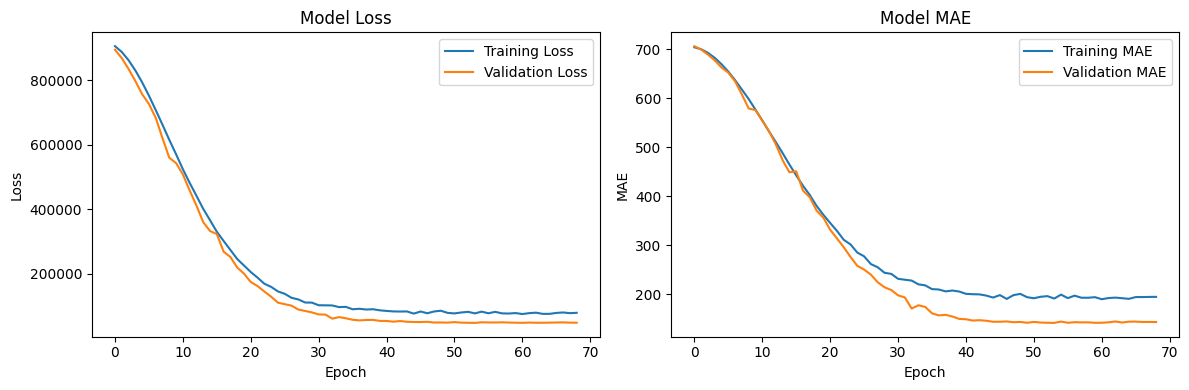

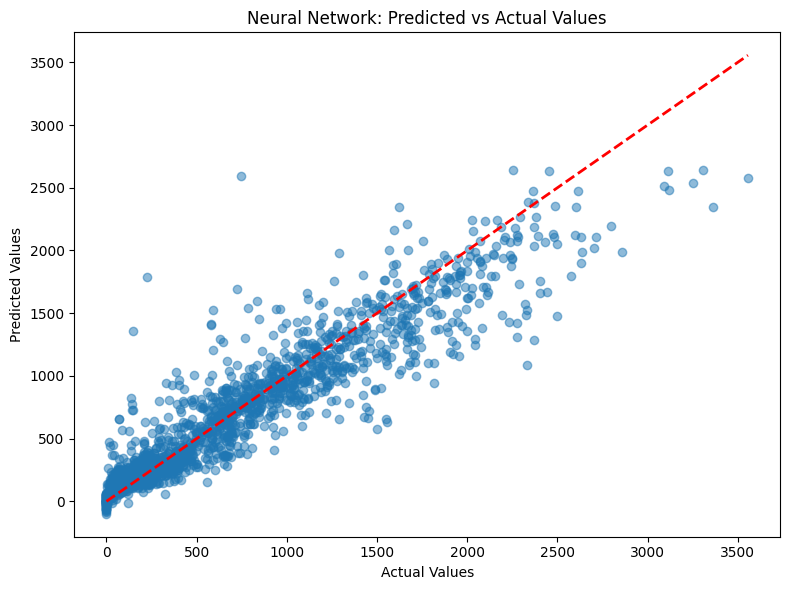


Neural Network Metrics:
MAE: 146.07
R²: 0.8689


In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate Neural Network
y_pred_nn = model.predict(X_test_transformed)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot for Neural Network predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

print("\nNeural Network Metrics:")
print(f"MAE: {mae_nn:.2f}")
print(f"R²: {r2_nn:.4f}")

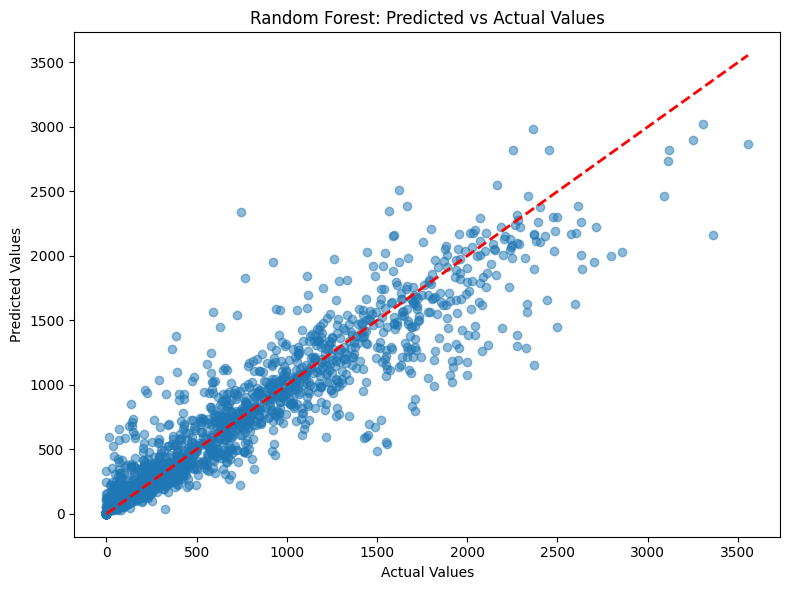


Random Forest Metrics:
MAE: 145.58
R²: 0.8639

Model Comparison:
            Model         MAE        R²
0  Neural Network  146.071492  0.868893
1   Random Forest  145.576507  0.863893


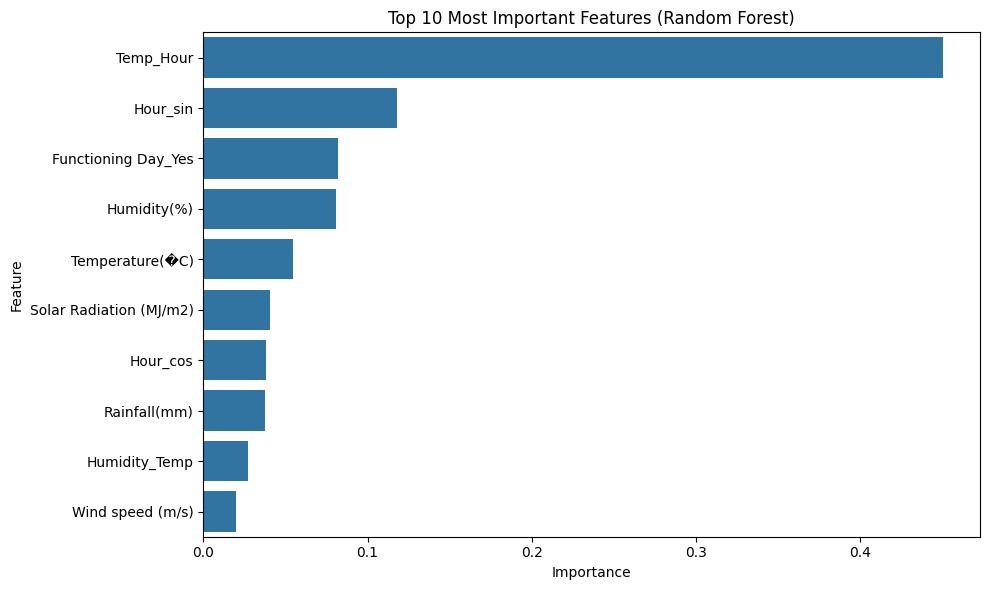

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_transformed, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_transformed)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Scatter plot for Random Forest predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

print("\nRandom Forest Metrics:")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

# Compare models
comparison_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest'],
    'MAE': [mae_nn, mae_rf],
    'R²': [r2_nn, r2_rf]
})
print("\nModel Comparison:")
print(comparison_df)

# Feature importance for Random Forest
feature_names = numeric_features + [f"{feat}_{cat}" for feat, cats in 
                                  zip(categorical_features, preprocessor.named_transformers_['cat'].categories_) 
                                  for cat in cats[1:]]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

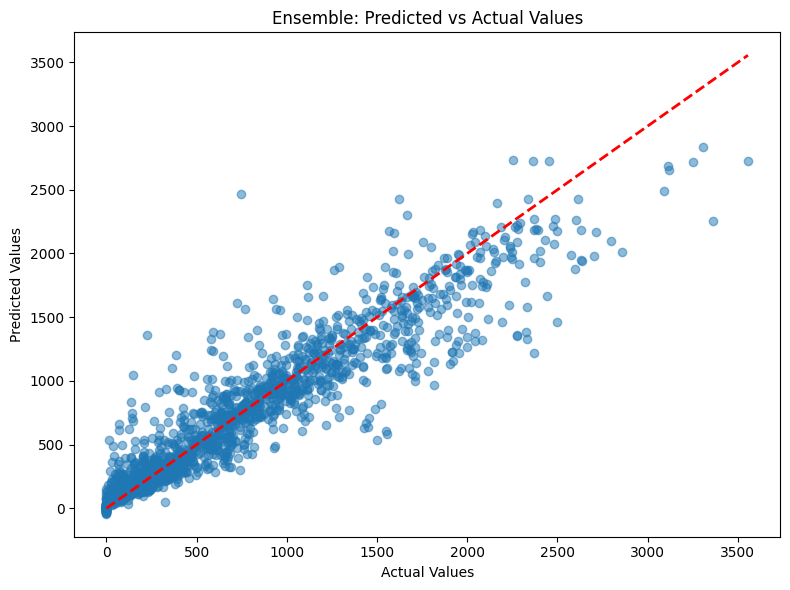


Final Model Comparison:
            Model         MAE        R²
0  Neural Network  146.071492  0.868893
1   Random Forest  145.576507  0.863893
2        Ensemble  140.391914  0.875241


In [19]:
# Create and evaluate ensemble predictions
y_pred_ensemble = (y_pred_nn.flatten() + y_pred_rf) / 2

# Calculate ensemble metrics
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Scatter plot for ensemble predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ensemble, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ensemble: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# Update comparison table with ensemble results
comparison_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'Ensemble'],
    'MAE': [mae_nn, mae_rf, mae_ensemble],
    'R²': [r2_nn, r2_rf, r2_ensemble]
})
print("\nFinal Model Comparison:")
print(comparison_df)

The bike sharing demand prediction project has been completed. The ensemble model, combining both Neural Network and Random Forest predictions, achieved the best performance with an MAE of 140.39 and R² of 0.875. The Neural Network and Random Forest models performed similarly, with the Neural Network having a slightly better R² score. The feature importance analysis shows that temperature, hour-related features, and humidity are among the most important predictors for bike rental demand.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3dc2a452-943f-4fc3-b0c9-21a20bef01eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>